# RescuExplorer
a Disaster Tweets Predictor by PlanetCare

In [146]:
import numpy as np
import pandas as pd
import string
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

from nltk.stem.snowball import stopwords
from wordcloud import WordCloud
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import torch.optim as opt
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
path = 'data/all_data_en/'
dftrain = pd.read_csv(path + 'crisis_consolidated_humanitarian_filtered_lang_en_train.tsv', sep='\t')
dftrain.head()

,id,event,source,text,lang,lang_conf,class_label
0,18582,disaster_events,drd-figureeight-multimedia,Approximately 100km long firebreaks have been ...,en,1.0,infrastructure_and_utilities_damage
1,592616302138658817,2015_nepal_earthquake,crisisnlp-volunteers,God bless you... https://t.co/AnEy1ydkkz,en,NaN,not_humanitarian
2,503643491143282688,2014_california_earthquake,crisisnlp-cf,"RT @perreaux: Cracked wine casks, damaged hist...",en,NaN,infrastructure_and_utilities_damage
3,323833109051228160,2013_boston_bombings-ontopic,crisislext6,I'm really just excited for new undies and pin...,en,1.0,not_humanitarian
4,508333923886067712,2014_pakistan_floods,crisisnlp-cf,"Rescue effort expands in India, Pakistan as fl...",en,1.0,injured_or_dead_people


In [3]:
# path = 'data/all_data_en/'
# dftest = pd.read_csv(path + 'crisis_consolidated_humanitarian_filtered_lang_en_dev.tsv', sep='\t')
# dftest.head()

# Eploratory Data Analysis

In [145]:
classes = dftrain.class_label.unique()

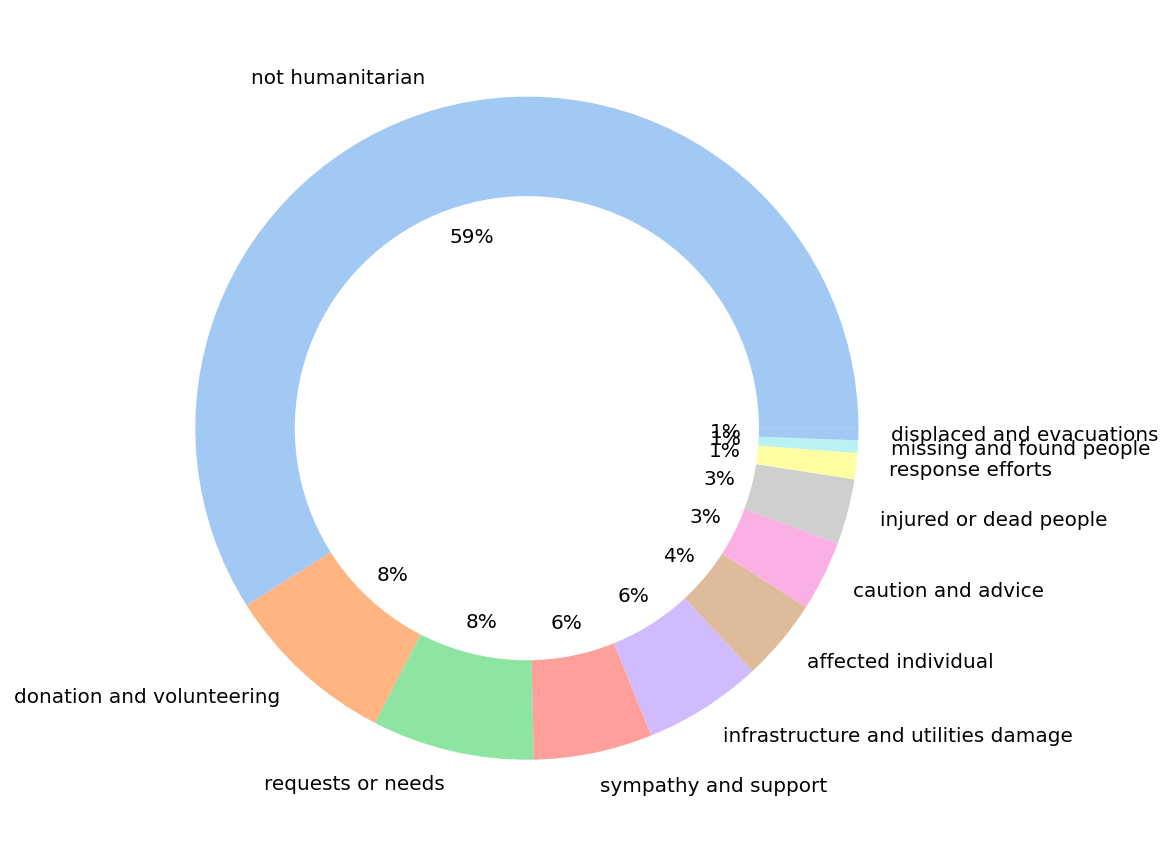

In [5]:
data = dftrain['class_label'].value_counts()
labels = ['not humanitarian', 'donation and volunteering', 'requests or needs',
       'sympathy and support', 'infrastructure and utilities damage',
       'affected individual', 'caution and advice', 'injured or dead people',
       'response efforts', 'missing and found people',
       'displaced and evacuations']
colors = sns.color_palette('pastel')[0:11]
plt.figure(figsize=(8, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) 
plt.tight_layout()

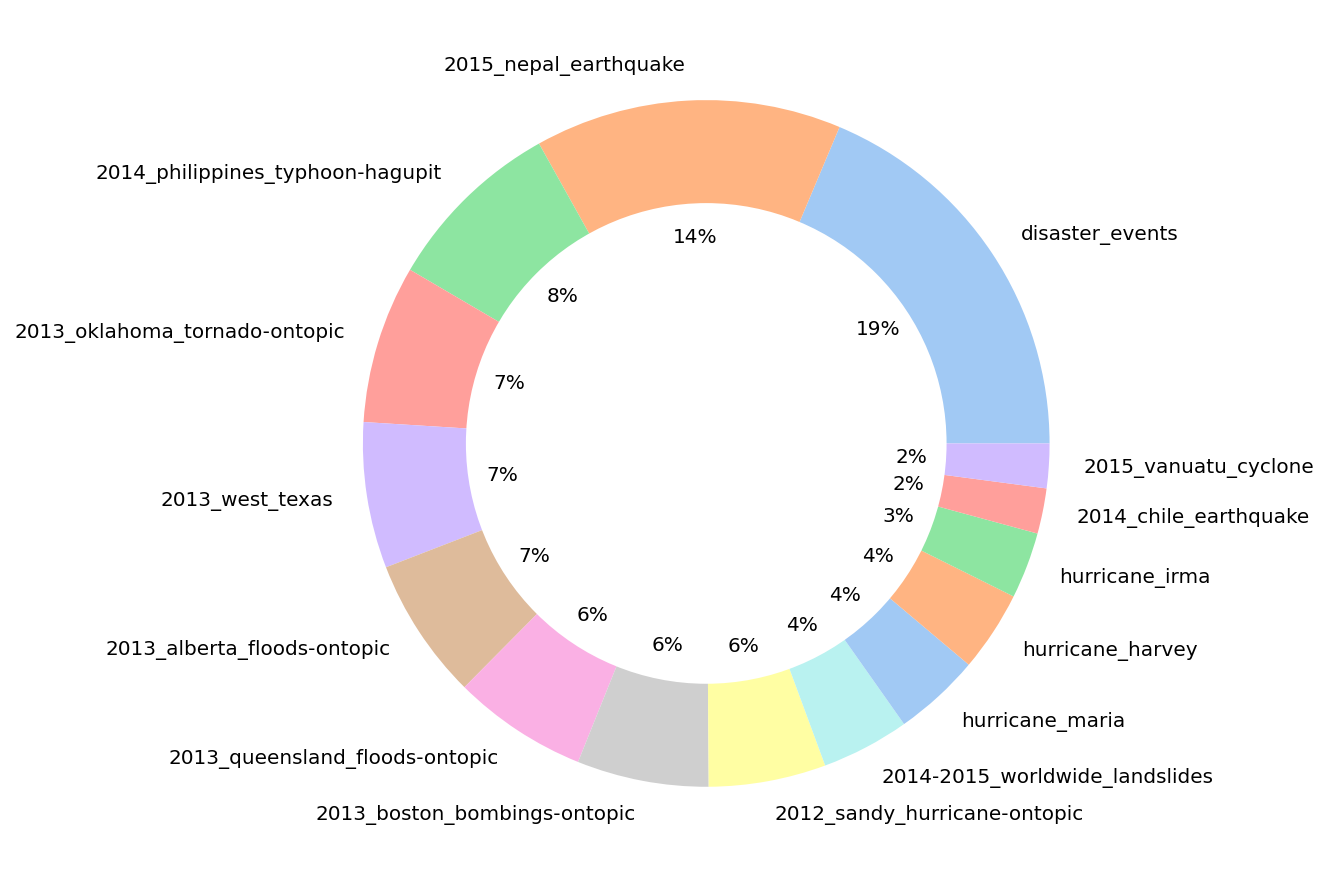

In [6]:
data = dftrain.event.value_counts()[:15]
labels = dftrain.event.value_counts()[:15].index
colors = sns.color_palette('pastel')[0:len(data)]
plt.figure(figsize=(9, 9))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) 
plt.tight_layout()

In [7]:
class_dict = {}
label = 0
for c in classes:
    class_dict[c] = label
    label += 1
class_dict

{'infrastructure_and_utilities_damage': 0,
 'not_humanitarian': 1,
 'injured_or_dead_people': 2,
 'sympathy_and_support': 3,
 'donation_and_volunteering': 4,
 'response_efforts': 5,
 'caution_and_advice': 6,
 'requests_or_needs': 7,
 'affected_individual': 8,
 'displaced_and_evacuations': 9,
 'missing_and_found_people': 10}

In [8]:
dftrain['class_label_encode'] = dftrain['class_label'].apply(lambda x: class_dict[x])
# dftest['class_label_encode'] = dftest['class_label'].apply(lambda x: class_dict[x])

# Data Wrangling

In [9]:
punctuation = set(string.punctuation)
stopwordsSet = set(stopwords.words("english"))
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789 '

def clean_text(text):
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('RT', '', text)
    text = re.sub('&amp;', '', text)
    text = ''.join(c for c in text.lower() if c not in punctuation and c in alphabet)
    text = ' '.join(w for w in text.split() if w not in stopwordsSet)
    return text

dftrain.text = dftrain.text.apply(lambda x: clean_text(x))
# dftest.text = dftest.text.apply(lambda x: clean_text(x))

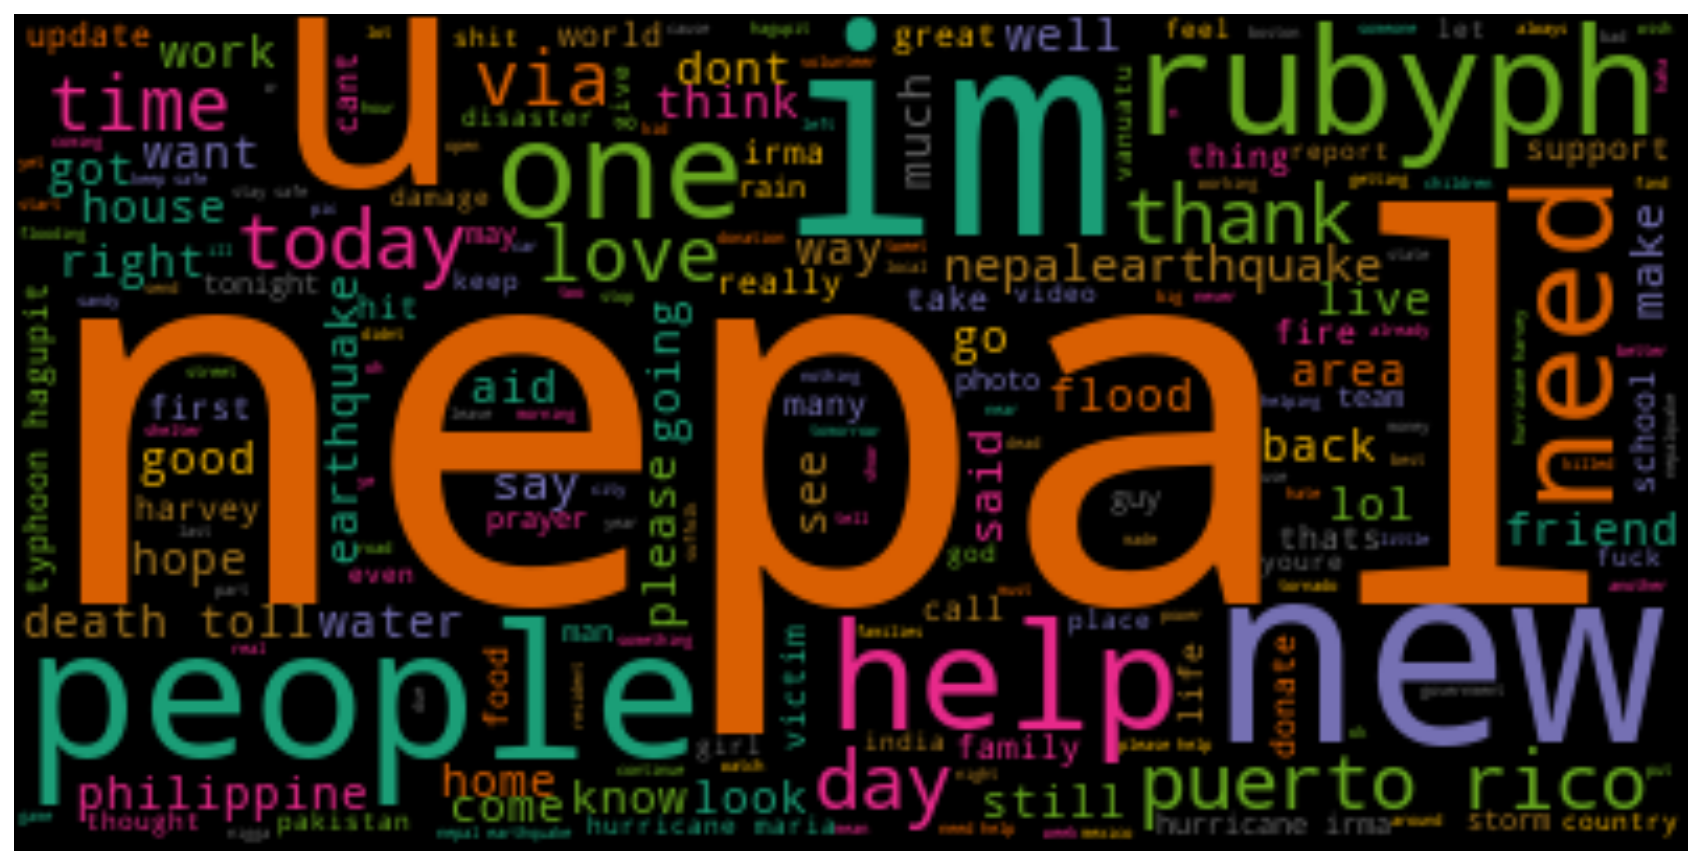

In [10]:
text = " ".join(d for d in dftrain['text'])
wordcloud = WordCloud(colormap="Dark2").generate(text)
fig = plt.figure(figsize=(15, 30))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [15]:
words_count = defaultdict(int)
for d in dftrain['text'].tolist():
    for w in set(d.split()):
        words_count[w] += 1
counts = sorted([(v,k) for k, v in words_count.items()], reverse=True)
first_1000_words = [i[1] for i in counts[:1000]]
first_1000_words[:10]

['nepal',
 'earthquake',
 'help',
 'people',
 'im',
 'rubyph',
 'like',
 'hurricane',
 'please',
 'need']

# Feature Engineering

In [11]:
datatrain = []
for index, row in dftrain.iterrows():
    datatrain.append(row.to_dict())
datatrain[0]

{'id': 18582,
 'event': 'disaster_events',
 'source': 'drd-figureeight-multimedia',
 'text': 'approximately 100km long firebreaks constructed indonesia elsewhere',
 'lang': 'en',
 'lang_conf': 1.0,
 'class_label': 'infrastructure_and_utilities_damage',
 'class_label_encode': 0}

In [13]:
# datatest = []
# for index, row in dftest.iterrows():
#     datatest.append(row.to_dict())

In [80]:
Xtrain = list(dftrain.text)
ytrain = list(dftrain.class_label_encode)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, ytrain, stratify=ytrain, random_state=42)
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

### TFIDF
for feature extraction

In [81]:
vectorizer = TfidfVectorizer(max_df=0.4, sublinear_tf=True)
Xtrain = vectorizer.fit_transform(Xtrain)
Xtest = vectorizer.transform(Xtest)

# Model Training

## Logistic Regression

In [104]:
modlog = LogisticRegression(max_iter=1000, C=3, solver='saga', n_jobs = -1)
modlog.fit(Xtrain,ytrain)
scores = cross_val_score(modlog, Xtrain, ytrain, scoring='accuracy', cv=skf)
cvlog = scores.mean()
cvlog

0.8078608245432388

In [105]:
pred = modlog.predict(Xtest)
f1log = f1_score(ytest,pred,average='weighted')
acclog = accuracy_score(ytest,pred)
f1log, acclog

(0.8119545026273967, 0.8219213916683016)

## SGD

In [19]:
search_space = {"loss": ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'epsilon': [0.05,0.1,0.2,0.3],
                'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
               'class_weight': [{0:10,1:1}, {0:1,1:1}, {0:1,1:10}]}

In [ ]:
mod = SGDClassifier()
grid_search = GridSearchCV(estimator=mod, param_grid=search_space, scoring='accuracy', cv=skf, verbose = 3, n_jobs = -1)
grid_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [16]:
acc=[]
m = 0

for l in ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']:
    print(l)
    mod = SGDClassifier(loss=l, max_iter=1000)
    mod.fit(Xtrain,ytrain)
    pred = mod.predict(Xtest)
    a = f1_score(ytest,pred,average='weighted')
    acc.append(a)
    print(a)
    if a > m:
        m = a
        bl = l

hinge
0.7697748900781977
log_loss
0.6949419667243847
modified_huber
0.8050991725753208
squared_hinge


C:\Users\ctric\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.7627225779509018
perceptron
0.7731963489418663
squared_error
0.7727928487886052
huber
0.5349541794787054
epsilon_insensitive
0.7257151407203042
squared_epsilon_insensitive
0.14255924030761918


C:\Users\ctric\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [17]:
m

0.8050991725753208

In [18]:
bl

'modified_huber'

In [118]:
modsgd = SGDClassifier(loss='modified_huber', learning_rate='adaptive', epsilon=0.05, eta0=0.1)
modsgd.fit(Xtrain,ytrain)
scores = cross_val_score(modsgd, Xtrain, ytrain, scoring='accuracy', cv=skf)
cvsgd = scores.mean()
cvsgd

0.8063131073540969

In [119]:
pred = modsgd.predict(Xtest)
f1sgd = f1_score(ytest,pred,average='weighted')
accsgd = accuracy_score(ytest,pred)
f1sgd, accsgd

(0.8045071749569337, 0.8172127395199791)

## XGBoost

In [122]:
mod = xgb.XGBClassifier(objective='multi:softmax', colsample_bytree=0.5, subsample = 0.5, num_class=11, n_jobs=-1)
mod.fit(Xtrain,ytrain)
scores = cross_val_score(mod, Xtrain, ytrain, scoring='accuracy', cv=skf)
cvxgb = scores.mean()
cvxgb

0.7797178449462377

In [123]:
pred = mod.predict(Xtest)
f1xgb = f1_score(ytest,pred,average='weighted')
accxgb = accuracy_score(ytest,pred)
f1xgb, accxgb

(0.7725705344139091, 0.7888300307370348)

# Results
for working models

In [133]:
dfacc = pd.DataFrame(columns=['Model', 'Training Accuracy', 'Test Accuracy'])
dfacc['Model'] = ['Logistic Regression', 'SGD Classifier', 'XGBoost']
dfacc['Training Accuracy'] = [cvlog, cvsgd, cvxgb]
dfacc['Test Accuracy'] = [acclog, accsgd, accxgb]
dfacc

,Model,Training Accuracy,Test Accuracy
0,Logistic Regression,0.807861,0.821921
1,SGD Classifier,0.806313,0.817213
2,XGBoost,0.779718,0.788830
3,MLP,~0.8,0.793669


In [115]:
label_dict = {value: key for key, value in class_dict.items()}

In [129]:
tweet = ['Just experienced a devastating earthquake in our city. 🚨 Our community needs \
         your support now more than ever! We\'re in urgent need of food, clean water, \
         medical supplies, and temporary shelter.']
tweet = vectorizer.transform(tweet)

pred = modlog.predict(tweet)[0]
label_dict[pred]

'requests_or_needs'

In [131]:
tweet2 = ['Numerous safe havens set up for those affected. Warm meals, clean water, \
          and comfort provided for our community. Hundreds of dedicated volunteers are \
          working tirelessly, lending a hand in cleanup and rebuilding.']
tweet2 = vectorizer.transform(tweet2)
pred = modsgd.predict(tweet2)[0]
label_dict[pred]

'donation_and_volunteering'

The models below are unsuccessful attemps since their accuracy rate are low.

## Decision Tree

In [76]:
mod = DecisionTreeClassifier(max_depth=100, max_features='sqrt')
mod.fit(Xtrain,ytrain)
scores = cross_val_score(mod, Xtrain, ytrain, scoring='accuracy', cv=skf)
cvdt = scores.mean()
cvdt

0.656312386206962

## MLP

In [242]:
mod = MLPClassifier(hidden_layer_sizes = 25, batch_size = 50, max_iter=10)
mod.fit(Xtrain,ytrain)
pred = mod.predict(Xtest)
f1_score(ytest,pred,average='weighted')

C:\Users\ctric\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.7964483173839539

In [104]:
accuracy_score(ytest,pred)

0.7936694787783664

## BERT

In [238]:
Xtrain = list(dftrain.text)[:4000]
ytrain = list(dftrain.class_label_encode)[:4000]
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, ytrain, stratify=ytrain, random_state=42)

In [175]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [225]:
Xtrainb = tokenizer.batch_encode_plus(Xtrain,padding=True,truncation=True,max_length=10,return_tensors='pt')

In [226]:
Xtestb = tokenizer.batch_encode_plus(Xtest,padding=True,truncation=True,max_length=10,return_tensors='pt')

In [227]:
idtrain = Xtrainb['input_ids']
masktrain = Xtrainb['attention_mask']
labeltrain = torch.tensor(ytrain)

In [228]:
idtest = Xtestb['input_ids']
masktest = Xtestb['attention_mask']
labeltest = torch.tensor(ytest)

In [229]:
datatrain = TensorDataset(idtrain, masktrain, labeltrain)
datatest = TensorDataset(idtest, masktest, labeltest)

In [231]:
loadtrain = DataLoader(datatrain, shuffle=True, num_workers=2, drop_last=True)
loadtest = DataLoader(datatest, shuffle=True, num_workers=2, drop_last=True)

In [230]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [232]:
optimizer = opt.AdamW(model.parameters(),lr=1e-5)

In [233]:
epochs = 1

In [234]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [235]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def acc_score_func(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return (pred_flat == labels_flat).mean()


In [236]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                  }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals


In [237]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(loadtrain,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        progress_bar.set_postfix(
            {'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write(f'\nEpoch {epoch}')

    # Train Eval
    loss_train_avg = loss_train_total/len(loadtrain)
    train_loss, train_predictions, true_trains = evaluate(loadtrain)
    train_acc = acc_score_func(train_predictions, true_trains)
    train_f1 = f1_score_func(train_predictions, true_trains)
    
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training Acc: {train_acc}, F1 (Weighted): {train_f1}')
    
    # validation Eval
    val_loss, predictions, true_vals = evaluate(loadtest)
    val_acc = acc_score_func(predictions, true_vals)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation Acc: {val_acc}, F1 (weighted): {val_f1}')


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3000 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/3000 [00:00<?, ?it/s]

Training loss: 1.5881192083287363
Training Acc: 0.725, F1 (Weighted): 0.6833376127058317


  0%|          | 0/1000 [00:00<?, ?it/s]

Validation loss: 1.3292608783382456
Validation Acc: 0.677, F1 (weighted): 0.6315544312596187


## KNN

In [90]:
for i in [1,3,5,7,9]:
    print(i)
    mod = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    mod.fit(Xtrain,ytrain)
    pred = mod.predict(Xtest)
    accuracy_score(ytest,pred)
    a = f1_score(ytest,pred,average='weighted')
    print(a)
    if a > m:
        m = a
        bi = i

1
0.5618601734548194
3
0.5079733627081587
5
0.4830118777610707
7
0.4699579163268503
9
0.4633559009129112


In [88]:
f1_score(ytest,pred,average='weighted')

0.4830118777610707

In [93]:
accuracy_score(ytest,pred)

0.6013341181086914

## Random Forest

In [289]:
mod = RandomForestClassifier(max_depth = 50, n_jobs = -1)
mod.fit(Xtrain,ytrain)
pred = mod.predict(Xtest)

In [290]:
accuracy_score(ytest,pred)

0.6208881041135308

In [292]:
f1_score(ytest,pred,average='weighted')

0.5019945184450242

In [ ]:
# mod = SVC(kernel='linear')
# mod.fit(Xtrain,ytrain)
# pred = mod.predict(Xtest)

# Results
for other models

In [144]:
dfacc2 = pd.DataFrame(columns=['Model', 'Test Accuracy'])
dfacc2['Model'] = ['Multi-Layer Perceptron', 'BERT', 'Random Forest', 'k-Nearest Neighbors', 'NER']
dfacc2['Test Accuracy'] = [0.7936694787783664, 0.6315544312596187, 0.6208881041135308, 0.6013341181086914, ' ']
dfacc2

,Model,Test Accuracy
0,Multi-Layer Perceptron,0.793669
1,BERT,0.631554
2,Random Forest,0.620888
3,k-Nearest Neighbors,0.601334
4,NER,
